In this workbook you will apply transfer learning to classify cats and dogs in images. 

Make sure you have GPU in 
Runtime -> Change Runtime type -> Hardware -> GPU 
and restart runtime if not. First we need to mount our google drive in order to have more space for saving or datasets.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
#move into your google drive folder
%cd  /content/gdrive 

/content/gdrive


In [0]:
%tensorflow_version 2.x
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import tensorflow_addons as tfa #extra addons 
import tensorflow_hub as hub
import os
import seaborn as sns
import random


# Getting data

In this workshop we will be using the dogs vs cats dataset.

The cats and dogs dataset unlike mnist is not pre-split into train/validation sets so lets do this ourselves. We will use 80% for training, 10% for validation and 10% for testing

In [4]:
(train_ds, validation_ds, test_ds), metadata = tfds.load('cats_vs_dogs',
split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
with_info=True,
as_supervised=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteAATRQC/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


print the metadata to see what the data contains

In [5]:
metadata 

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

plot some examples of the images and print the label

image shape:  (262, 350, 3)
label: 1
image shape:  (409, 336, 3)
label: 1
image shape:  (493, 500, 3)
label: 1
image shape:  (375, 500, 3)
label: 0
image shape:  (240, 320, 3)
label: 1


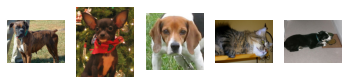

In [6]:
dataset = train_ds.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label) 
).take(5
)

f, axarr = plt.subplots(1,5)

i = 0
for image, label in dataset:
  print('image shape: ', np.shape(image));
  tf.print('label:',label);
  axarr[i].imshow(image);
  axarr[i].axis('off');
  i=i+1


As you can see the images take difference shapes. So first we need to read the images in with the same shape and we will also add augmentation. See: 

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/image   
https://www.tensorflow.org/addons/api_docs/python/tfa/image

for complete list.

Let's take 5 images to start with and plot them to see what the augmentation looks like

In [0]:
train = train_ds.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label) 
).cache( #cache images
).map( # resize for input
      lambda image, label: (tf.image.resize(image, [200,200]),label)
).map( # random horizontal flip
    lambda image, label: (tf.image.random_flip_left_right(image), label)
).map( # random translation
    lambda image, label: (tfa.image.translate(image, tf.random.uniform(shape=[2],minval=-5, maxval=5)), label)
).take(5
)

image shape:  (200, 200, 3)
label: 1
image shape:  (200, 200, 3)
label: 1
image shape:  (200, 200, 3)
label: 1
image shape:  (200, 200, 3)
label: 0
image shape:  (200, 200, 3)
label: 1


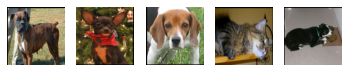

In [8]:
f, axarr = plt.subplots(1,5)

i = 0
for image, label in train:
  print('image shape: ', np.shape(image));
  tf.print('label:',label);
  axarr[i].imshow(image);
  axarr[i].axis('off');
  i=i+1


Now lets get the whole datasets for train/validation/test we will take 800 for training in batches of 20, 100 for validation in batches of 10 and 100 for test.

In [0]:
train = train_ds.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label) 
).cache( #cache images
).map( # resize for input
      lambda image, label: (tf.image.resize(image, [224,224]),label)
).map( # random horizontal flip
    lambda image, label: (tf.image.random_flip_left_right(image), label)
).map( # random translation
    lambda image, label: (tfa.image.translate(image, tf.random.uniform(shape=[2],minval=-5, maxval=5)), label)
).shuffle(100
).batch(24
).take(1)

valid = validation_ds.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label) 
).map( # resize for input
      lambda image, label: (tf.image.resize(image, [224,224]),label)
).shuffle(100
).batch(24
).take(1)

test = test_ds.map(
    lambda image, label: (tf.image.convert_image_dtype(image, tf.float64), label) 
).map( # resize for input
      lambda image, label: (tf.image.resize(image, [224,224]),label)
).batch(100
).take(1)

# Getting the model

We will use a pre-trained model. We will be using MobileNetV2_1.0_224.

This model is mobilenet version 2 with a depth multiplier of 1.0 trained on 224x224 images. This version has much fewer parameters than mobilenetV1. The model can be loaded as a keras layer. Lets read in the network and see what variables it contains and how many of them

In [11]:
mbnet = tf.keras.applications.MobileNetV2(include_top=False, weights=None)

nvar =  np.shape(mbnet.trainable_variables)[0]
print('number of variables: ', nvar)
for i in np.arange(nvar): 
  print(mbnet.trainable_variables[i].name) #variables name name
  print(mbnet.trainable_variables[i].shape) #kernel shape

number of variables:  156
Conv1_1/kernel:0
(3, 3, 3, 32)
bn_Conv1_1/gamma:0
(32,)
bn_Conv1_1/beta:0
(32,)
expanded_conv_depthwise_1/depthwise_kernel:0
(3, 3, 32, 1)
expanded_conv_depthwise_BN_1/gamma:0
(32,)
expanded_conv_depthwise_BN_1/beta:0
(32,)
expanded_conv_project_1/kernel:0
(1, 1, 32, 16)
expanded_conv_project_BN_1/gamma:0
(16,)
expanded_conv_project_BN_1/beta:0
(16,)
block_1_expand_1/kernel:0
(1, 1, 16, 96)
block_1_expand_BN_1/gamma:0
(96,)
block_1_expand_BN_1/beta:0
(96,)
block_1_depthwise_1/depthwise_kernel:0
(3, 3, 96, 1)
block_1_depthwise_BN_1/gamma:0
(96,)
block_1_depthwise_BN_1/beta:0
(96,)
block_1_project_1/kernel:0
(1, 1, 96, 24)
block_1_project_BN_1/gamma:0
(24,)
block_1_project_BN_1/beta:0
(24,)
block_2_expand_1/kernel:0
(1, 1, 24, 144)
block_2_expand_BN_1/gamma:0
(144,)
block_2_expand_BN_1/beta:0
(144,)
block_2_depthwise_1/depthwise_kernel:0
(3, 3, 144, 1)
block_2_depthwise_BN_1/gamma:0
(144,)
block_2_depthwise_BN_1/beta:0
(144,)
block_2_project_1/kernel:0
(1, 1, 14

In [0]:
tf.keras.backend.clear_session() #Clear keras session

# Training from scratch

We are going to add a dropout layer and new dense layer for the 2 classes we have (cats and dogs). Firstly I want you to try and fit the network without transfer learning

In [13]:
dropoutrate = 0.2
num_classes = 2
input_shape = [224,224,3]

mbnet = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights=None) 

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(num_classes, activation='softmax') 
])
model.build()

model.summary() # print the model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


In [0]:
with tf.GradientTape() as tape:
  tape.reset() #this resets the gradient tape

In [0]:
LR = 0.001 #learning rate
optimizer = tf.optimizers.Adam(LR) #adam optimiser

def train_step( model, X , Y):
    with tf.GradientTape() as tape:
        pred = model( X )
        current_loss = tf.reduce_mean(tf.losses.categorical_crossentropy( Y,  pred))
    grads = tape.gradient(current_loss, model.trainable_variables) 
    optimizer.apply_gradients( zip( grads , model.trainable_variables) ) #update gradients of all layers
    current_accuracy = tf.reduce_mean(tf.metrics.categorical_accuracy(Y, pred))
    return(current_loss, current_accuracy)

In [16]:
niter = 1000

tloss = []
tacc = []
vloss = []
vacc = []

for it in range(niter):
    for image, label in train:
        loss, acc = train_step( model , image , tf.one_hot(label, depth=2) ) #run training

    if it % 10 is 0: #log training metrics
      tf.print('iter: ',it, ', loss: {:.3f}, acc: {:.3f}'.format(loss, acc))
      tloss.append(loss)
      tacc.append(acc)

    if it % 50 is 0: #log validation metrics
      for val_image, val_label in valid:
        val_pred = model(val_image)
        val_loss = tf.reduce_mean(tf.losses.categorical_crossentropy(tf.one_hot(val_label, depth=2), val_pred))
        val_acc = tf.reduce_mean(tf.metrics.categorical_accuracy(tf.one_hot(val_label, depth=2), val_pred))
        tf.print('iter: ',it, ', validation loss: {:.3f}, validation acc: {:.3f}'.format(val_loss, val_acc))
        vloss.append(val_loss)
        vacc.append(val_acc)


iter:  0 , loss: 0.693, acc: 0.458
iter:  0 , validation loss: 0.690, validation acc: 0.583
iter:  10 , loss: 0.582, acc: 0.792
iter:  20 , loss: 0.723, acc: 0.375
iter:  30 , loss: 0.697, acc: 0.500
iter:  40 , loss: 0.638, acc: 0.708
iter:  50 , loss: 0.639, acc: 0.667
iter:  50 , validation loss: 0.771, validation acc: 0.417
iter:  60 , loss: 0.656, acc: 0.667
iter:  70 , loss: 0.733, acc: 0.375
iter:  80 , loss: 0.712, acc: 0.458
iter:  90 , loss: 0.696, acc: 0.542
iter:  100 , loss: 0.719, acc: 0.500
iter:  100 , validation loss: 0.681, validation acc: 0.583
iter:  110 , loss: 0.697, acc: 0.542
iter:  120 , loss: 0.680, acc: 0.583
iter:  130 , loss: 0.659, acc: 0.708
iter:  140 , loss: 0.682, acc: 0.583
iter:  150 , loss: 0.635, acc: 0.750
iter:  150 , validation loss: 0.703, validation acc: 0.500
iter:  160 , loss: 0.693, acc: 0.542
iter:  170 , loss: 0.680, acc: 0.583
iter:  180 , loss: 0.744, acc: 0.375
iter:  190 , loss: 0.670, acc: 0.625
iter:  200 , loss: 0.712, acc: 0.458
i

Now let's evaluate the results by plotting the Loss and Accuracy. The network here performs badly because we have a huge model with loads of parameters but not much data to fit it with. 

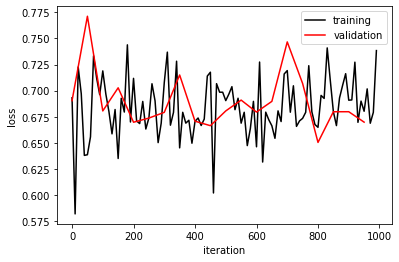

In [17]:
titers = 10*np.arange(np.shape(tloss)[0])
viters = 50*np.arange(np.shape(vloss)[0])

plt.plot(titers, tloss, c='black', label='training');
plt.plot(viters, vloss, c='r', label='validation');
plt.legend();
plt.xlabel('iteration');
plt.ylabel('loss');

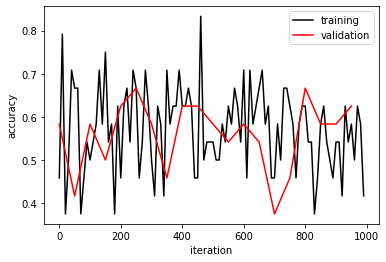

In [18]:
plt.plot(titers, tacc, c='black', label='training');
plt.plot(viters, vacc, c='r', label='validation');
plt.legend();
plt.xlabel('iteration');
plt.ylabel('accuracy');

# Transfer learning

Now we will implement transfer learning from the imagenet weights.

In [0]:
tf.keras.backend.clear_session() #Clear keras session

In [20]:
dropoutrate = 0.2
num_classes = 2
input_shape = [224,224,3]

mbnet = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet') #We now dont want randomized weights but to load weights from imagenet

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(num_classes, activation='softmax') 
])
model.build()

mbnet.trainable = False # freeze the first layers to the imagenet weights

model.summary() # print the model

9412608/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
with tf.GradientTape() as tape:
  tape.reset() #this resets the gradient tape

In [0]:
LR = 0.001 #learning rate
optimizer = tf.optimizers.Adam(LR) #adam optimiser

def train_step( model, X , Y):
    with tf.GradientTape() as tape:
        pred = model( X )
        current_loss = tf.reduce_mean(tf.losses.categorical_crossentropy( Y,  pred))
    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients( zip( grads , model.trainable_variables) )
    current_accuracy = tf.reduce_mean(tf.metrics.categorical_accuracy(Y, pred))
    return(current_loss, current_accuracy)

In [23]:
niter = 1000

tloss = []
tacc = []
vloss = []
vacc = []

for it in range(niter):
    for image, label in train:
        loss, acc = train_step( model , image , tf.one_hot(label,depth=2) ) #run training

    if it % 10 is 0: #log training metrics
      tf.print('iter: ',it, ', loss: {:.3f}, acc: {:.3f}'.format(loss, acc))
      tloss.append(loss)
      tacc.append(acc)

    if it % 50 is 0: #log validation metrics
      for val_image, val_label in valid:
        val_pred = model(val_image)
        val_loss = tf.reduce_mean(tf.losses.categorical_crossentropy(tf.one_hot(val_label,depth=2) , val_pred))
        val_acc = tf.reduce_mean(tf.metrics.categorical_accuracy(tf.one_hot(val_label,depth=2) , val_pred))
        tf.print('iter: ',it, ', validation loss: {:.3f}, validation acc: {:.3f}'.format(val_loss, val_acc))
        vloss.append(val_loss)
        vacc.append(val_acc)


iter:  0 , loss: 0.745, acc: 0.458
iter:  0 , validation loss: 0.578, validation acc: 0.750
iter:  10 , loss: 0.168, acc: 1.000
iter:  20 , loss: 0.049, acc: 1.000
iter:  30 , loss: 0.042, acc: 1.000
iter:  40 , loss: 0.020, acc: 1.000
iter:  50 , loss: 0.023, acc: 1.000
iter:  50 , validation loss: 0.038, validation acc: 1.000
iter:  60 , loss: 0.013, acc: 1.000
iter:  70 , loss: 0.013, acc: 1.000
iter:  80 , loss: 0.018, acc: 1.000
iter:  90 , loss: 0.012, acc: 1.000
iter:  100 , loss: 0.010, acc: 1.000
iter:  100 , validation loss: 0.060, validation acc: 1.000
iter:  110 , loss: 0.009, acc: 1.000
iter:  120 , loss: 0.011, acc: 1.000
iter:  130 , loss: 0.005, acc: 1.000
iter:  140 , loss: 0.005, acc: 1.000
iter:  150 , loss: 0.005, acc: 1.000
iter:  150 , validation loss: 0.062, validation acc: 0.958
iter:  160 , loss: 0.009, acc: 1.000
iter:  170 , loss: 0.004, acc: 1.000
iter:  180 , loss: 0.010, acc: 1.000
iter:  190 , loss: 0.006, acc: 1.000
iter:  200 , loss: 0.005, acc: 1.000
i

Plot the metrics. Notice how much better we perform with adding the trained weights. 

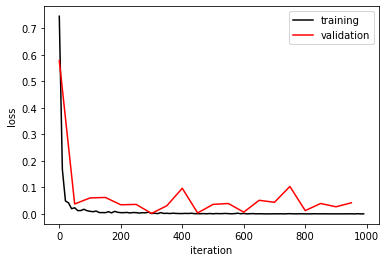

In [28]:
titers = 10*np.arange(np.shape(tloss)[0])
viters = 50*np.arange(np.shape(vloss)[0])

plt.plot(titers, tloss, c='black', label='training');
plt.plot(viters, vloss, c='r', label='validation');
plt.legend();
plt.xlabel('iteration');
plt.ylabel('loss');

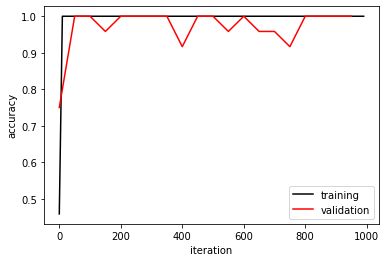

In [29]:
plt.plot(titers, tacc, c='black', label='training');
plt.plot(viters, vacc, c='r', label='validation');
plt.legend();
plt.xlabel('iteration');
plt.ylabel('accuracy');

# Save weights

Lets save the trained weights into hdf5 format

In [0]:
model.save_weights('/content/gdrive/My Drive/Colab Notebooks/my_weights.hdf5')


Now we clear the last keras session and make a new model where the mobilenet part is trainable. Note there are millions more trainable parameters but we can set the training rate to a low value.

In [0]:
tf.keras.backend.clear_session() #Clear keras session

# Load weights

Load previously saved weights onto new model

In [32]:
dropoutrate = 0.2
num_classes = 2
input_shape = [224,224,3]

mbnet = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet') #We now dont want randomized weights but to load weights from imagenet

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(num_classes, activation='softmax') 
])
model.build()

mbnet.trainable = False # freeze the first layers to the imagenet weights

model.summary() # print the model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.load_weights('/content/gdrive/My Drive/Colab Notebooks/my_weights.hdf5')

In [34]:
#unfreeze layers 
mbnet.trainable = True # freeze the first layers to the imagenet weights
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


# Fine tuning
Further fine tune the model by training with a smaller learning rate

In [0]:
LR = 0.00001 #learning rate
optimizer = tf.optimizers.Adam(LR) #adam optimiser

def train_step( model, X , Y):
    with tf.GradientTape() as tape:
        pred = model( X )
        current_loss = tf.reduce_mean(tf.losses.categorical_crossentropy( Y,  pred))
    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients( zip( grads , model.trainable_variables) )
    current_accuracy = tf.reduce_mean(tf.metrics.categorical_accuracy(Y, pred))
    return(current_loss, current_accuracy)

In [36]:
niter = 1000

tloss = []
tacc = []
vloss = []
vacc = []

for it in range(niter):
    for image, label in train:
        loss, acc = train_step( model , image , tf.one_hot(label,depth=2) ) #run training

    if it % 10 is 0: #log training metrics
      tf.print('iter: ',it, ', loss: {:.3f}, acc: {:.3f}'.format(loss, acc))
      tloss.append(loss)
      tacc.append(acc)

    if it % 50 is 0: #log validation metrics
      for val_image, val_label in valid:
        val_pred = model(val_image)
        val_loss = tf.reduce_mean(tf.losses.categorical_crossentropy(tf.one_hot(val_label,depth=2) , val_pred))
        val_acc = tf.reduce_mean(tf.metrics.categorical_accuracy(tf.one_hot(val_label,depth=2) , val_pred))
        tf.print('iter: ',it, ', validation loss: {:.3f}, validation acc: {:.3f}'.format(val_loss, val_acc))
        vloss.append(val_loss)
        vacc.append(val_acc)


iter:  0 , loss: 0.001, acc: 1.000
iter:  0 , validation loss: 0.008, validation acc: 1.000
iter:  10 , loss: 0.000, acc: 1.000
iter:  20 , loss: 0.000, acc: 1.000
iter:  30 , loss: 0.000, acc: 1.000
iter:  40 , loss: 0.000, acc: 1.000
iter:  50 , loss: 0.000, acc: 1.000
iter:  50 , validation loss: 0.050, validation acc: 1.000
iter:  60 , loss: 0.000, acc: 1.000
iter:  70 , loss: 0.000, acc: 1.000
iter:  80 , loss: 0.000, acc: 1.000
iter:  90 , loss: 0.000, acc: 1.000
iter:  100 , loss: 0.000, acc: 1.000
iter:  100 , validation loss: 0.002, validation acc: 1.000
iter:  110 , loss: 0.000, acc: 1.000
iter:  120 , loss: 0.000, acc: 1.000
iter:  130 , loss: 0.000, acc: 1.000
iter:  140 , loss: 0.000, acc: 1.000
iter:  150 , loss: 0.000, acc: 1.000
iter:  150 , validation loss: 0.001, validation acc: 1.000
iter:  160 , loss: 0.000, acc: 1.000
iter:  170 , loss: 0.000, acc: 1.000
iter:  180 , loss: 0.000, acc: 1.000
iter:  190 , loss: 0.000, acc: 1.000
iter:  200 , loss: 0.000, acc: 1.000
i

# One shot learning 

In this section we are going to write a siamese network that takes a sentence and classifies it using one shot learning and transferred weights from Googles Universal sentence encoder (USE) from tensor hub (https://tfhub.dev/) which is a hub for pre-trained models


In [37]:
# load the pre-trained model
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" 
USE = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder-large/5 loaded


The USE model, encodes words, sentences and paragraphs as a 512 size embedding. 

In [38]:
word = "Elephant"
sentence = "Machine learning in science is fun."
paragraph = (
    "Transfer learning is when we take domain knowledge and apply it to another problem. "
    "Here we will encode a paragraph, there's not limit to size but larger  "
    "paragraphs have more diluted embeddings.")
messages = [word, sentence, paragraph]


message_embeddings = USE(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [-0.0345856174826622, -0.0179901123046875, 0.0019805775955319405, ...]

Message: Machine learning in science is fun.
Embedding size: 512
Embedding: [0.08318386226892471, -0.05488215386867523, 0.06341148167848587, ...]

Message: Transfer learning is when we take domain knowledge and apply it to another problem. Here we will encode a paragraph, there's not limit to size but larger  paragraphs have more diluted embeddings.
Embedding size: 512
Embedding: [0.05429772660136223, -0.04880339279770851, -0.014501828700304031, ...]



The simplest model we can build is to apply the pre-trained model to pairs of sentences and apply the inner produce to get the similarity of the encodings. Let's make a dataset of sentences and see how the pre-trained model performs.

In [0]:
my_sentences = [
    # Weather 
    "The weather is lovely today.",
    "It's going to be sunny later",
    "The weather forcast is nice",

    # Questions
    "What is your dog called?",
    "What is your puppies name?",

    # Food 
    "Apples are delicious",
    "I like to eat pears",
    "I love the taste of peaches",
     
     # cars AI
    "Autonomous vehicles use machine learning algorithms.",
    "Self-driving cars are AI technology." 
]

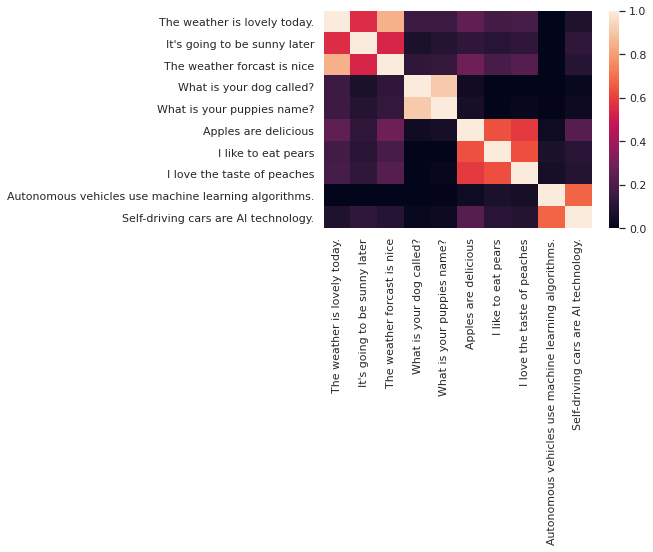

In [40]:
features = USE(my_sentences); # apply pre-trained USE model on each sentence
corr = np.inner(features, features); #calculate inner product 

#plot correlations
sns.set(font_scale=1);
g = sns.heatmap(
  corr,
  xticklabels=my_sentences,
  yticklabels=my_sentences,
  vmin=0,
  vmax=1);
g.set_xticklabels(my_sentences, rotation=90);

As you can see in the plot, where pixels values of 1 correspond to high correlation and 0 to no correlation, just taking the pre-trained model we get good correlation along the diagonal and clusters of high correlation around the groups of sentences that are related. 

Now let's code a siamese network model, as a feature extraction to see if we can improve the correlations.  First we make a dataset of pairs of sentences, and we will define a label for it of 1 if the pair is similar and 0 if they are not similar. To do this we make a training data set by randomly sampling pairs of x, and if their labels are the same (same group) then the similarity label will be 1, and otherwise the label is 0.



In [0]:
X = np.array(["The weather is nice.",
     "It's sunny.",
     "Today the weather is sunny",
     "Later the forecast is lovely",
     
     "What's the dog's name?",
     "What do you call the dog?",
     "What are the puppies called?",
     
     "Apples are delectable",
     "I think oranges are yummy", 
     "Pears are soo good",
     "Plums are delicious",
     
     "automobiles are now autonomous",
     "Many cabs are becoming self-driving",
     "car are intelligent"
])

Y = np.array([1,1,1,1,2,2,2,3,3,3,3,4,4,4])

In [0]:
xloc = [random.randint(0,13) for i in range(0,59)] #our data set will consist of 60 pairs of sentences (x,y) with labels
yloc = [random.randint(0,13) for i in range(0,59)]
x = X[xloc]
y = X[yloc]
labels = np.equal(Y[xloc],Y[yloc]).astype('int')

In [48]:
#print 20 examples of extracted pairs and labels 
[print(x[i],' ', y[i],' ', labels[i]) for i in np.arange(19)];

I think oranges are yummy   What's the dog's name?   0
The weather is nice.   The weather is nice.   1
Apples are delectable   Pears are soo good   1
Apples are delectable   It's sunny.   0
Later the forecast is lovely   What are the puppies called?   0
car are intelligent   Later the forecast is lovely   0
car are intelligent   It's sunny.   0
automobiles are now autonomous   What are the puppies called?   0
Pears are soo good   Today the weather is sunny   0
I think oranges are yummy   Later the forecast is lovely   0
automobiles are now autonomous   Apples are delectable   0
Today the weather is sunny   What do you call the dog?   0
Many cabs are becoming self-driving   What do you call the dog?   0
The weather is nice.   I think oranges are yummy   0
What's the dog's name?   What do you call the dog?   1
It's sunny.   What do you call the dog?   0
I think oranges are yummy   What's the dog's name?   0
It's sunny.   I think oranges are yummy   0
What's the dog's name?   Pears are so

We write a siamese neural network that consists of 2 USE blocks that read in each of the pairs and applies the USE network to get the encoding. Then, we add a L1 difference layer and a sigmoid activation layer 

In [0]:
tf.keras.backend.clear_session() #Clear keras session

In [0]:
input1 = tf.keras.layers.Input(shape=[],name='input1', dtype=tf.string)
input2 = tf.keras.layers.Input(shape=[],name='input2', dtype=tf.string)

# Parallel USE layers
embedding_layer = hub.KerasLayer(module_url, dtype=tf.string)
embedding1 = embedding_layer(input1)
embedding2 = embedding_layer(input2)
  
# L1 difference between the embedding outputs from the USE layers
L1_layer = tf.keras.layers.Lambda(lambda x:tf.math.abs(x[0] - x[1]))
L1_distance = L1_layer([embedding1, embedding2])

# Final fully connected layer with sigmoid so output is between 0-1
Dense_layer = tf.keras.layers.Dense(1, activation='sigmoid')(L1_distance)

model = tf.keras.Model(inputs=[input1,input2], outputs=Dense_layer)

In [51]:
model.summary() #Note that the USE layers have no trainable parameters whereas the FC layer does. 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(None,)]            0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 512)          147354880   input1[0][0]                     
                                                                 input2[0][0]                     
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512)          0           keras_layer[0][0]            

Compile and fit the networks. 

In [0]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None)

In [53]:
model.fit(x={'input1':np.array(x), 'input2':np.array(y)}, y=np.array(labels), batch_size=5, epochs=100, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False)


Train on 59 samples
Epoch 1/100
59/59 [==============================] - 28s 473ms/sample - loss: 0.6290
Epoch 2/100
59/59 [==============================] - 1s 9ms/sample - loss: 0.5502
Epoch 3/100
59/59 [==============================] - 0s 7ms/sample - loss: 0.4895
Epoch 4/100
59/59 [==============================] - 0s 8ms/sample - loss: 0.4412
Epoch 5/100
59/59 [==============================] - 0s 7ms/sample - loss: 0.4090
Epoch 6/100
59/59 [==============================] - 0s 7ms/sample - loss: 0.3839
Epoch 7/100
59/59 [==============================] - 0s 7ms/sample - loss: 0.3659
Epoch 8/100
59/59 [==============================] - 0s 7ms/sample - loss: 0.3531
Epoch 9/100
59/59 [==============================] - 0s 8ms/sample - loss: 0.3427
Epoch 10/100
59/59 [==============================] - 0s 7ms/sample - loss: 0.3355
Epoch 11/100
59/59 [==============================] - 1s 9ms/sample - loss: 0.3291
Epoch 12/100
59/59 [==============================] - 0s 8ms/sample - los

Get the similarities between sentences in my_sentences using the newly trained model.

In [0]:
features = [model.predict({'input1':np.array([ix]), 'input2':np.array([iy])})[0][0] for ix in my_sentences for iy in my_sentences]

Reshape the similarity values and plot correlation matrix

In [0]:
corr = np.reshape(features, (10,10))

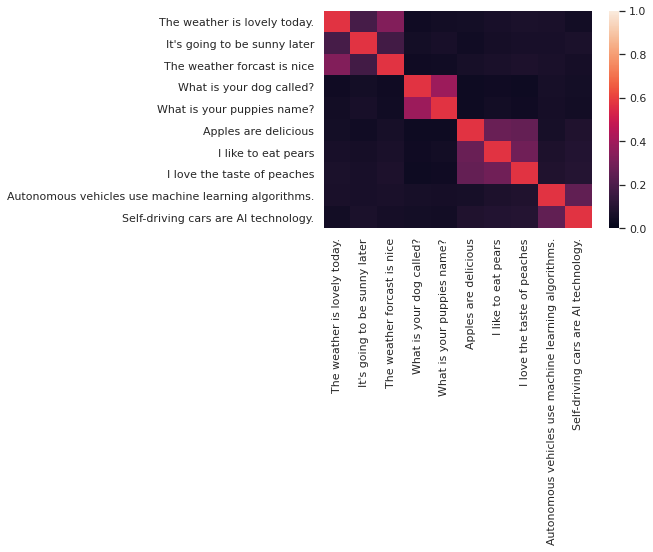

In [56]:
g = sns.heatmap(
  corr,
  xticklabels=my_sentences,
  yticklabels=my_sentences,
  vmin=0,
  vmax=1);
g.set_xticklabels(my_sentences, rotation=90);

As you can see, even with as small as 60 training samples, we are able to improve the correlation between related sentences even though these sentences have never been seen by the network before. Fine-tuning could help here, and using a categorical cross entropy loss would be better to split up the different sentence groups.